<a href="https://colab.research.google.com/github/narwhalhorned/solar-energy-prediction/blob/main/LSTM_Based_Time_Series_Analysis_for_Solar_Energy_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Exploratory Data Analysis

### Import

In [19]:
pip install tensorflow

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import statsmodels.api as sm
import matplotlib.dates as mdates
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import time
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from google.colab import drive


In [21]:
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/data/Solar_Energy_Production.csv'
df = pd.read_csv(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
df.head()

name      id        address  \
0  Calgary Fire Hall Headquarters  314106  1212 42 AV SE   
1  Calgary Fire Hall Headquarters  314106  1212 42 AV SE   
2  Calgary Fire Hall Headquarters  314106  1212 42 AV SE   
3  Calgary Fire Hall Headquarters  314106  1212 42 AV SE   
4  Calgary Fire Hall Headquarters  314106  1212 42 AV SE   

                     date    kWh  \
0  2017/09/11 08:00:00 AM  1.130   
1  2017/09/11 09:00:00 AM  2.340   
2  2017/09/11 10:00:00 AM  3.656   
3  2017/09/11 11:00:00 AM  4.577   
4  2017/09/11 12:00:00 PM  6.506   

                                          public_url installationDate  \
0  https://monitoring.solaredge.com/solaredge-web...       2016/11/07   
1  https://monitoring.solaredge.com/solaredge-web...       2016/11/07   
2  https://monitoring.solaredge.com/solaredge-web...       2016/11/07   
3  https://monitoring.solaredge.com/solaredge-web...       2016/11/07   
4  https://monitoring.solaredge.com/solaredge-web...       2016/11/07   

                         uid  
0  3141062017-09-11 08:00:00  
1  3141062017-09-11 09:00:00  
2  3141062017-09-11 10:00:00  
3  3141062017-09-11 11:00:00  
4  3141062017-09-11 12:00:00

Remove unnecessary columns

In [23]:
filtered_df = df.drop(['id', 'address', 'public_url','installationDate', 'uid'], axis=1)

In [24]:
filtered_df.head()

name                    date    kWh
0  Calgary Fire Hall Headquarters  2017/09/11 08:00:00 AM  1.130
1  Calgary Fire Hall Headquarters  2017/09/11 09:00:00 AM  2.340
2  Calgary Fire Hall Headquarters  2017/09/11 10:00:00 AM  3.656
3  Calgary Fire Hall Headquarters  2017/09/11 11:00:00 AM  4.577
4  Calgary Fire Hall Headquarters  2017/09/11 12:00:00 PM  6.506

Checking the amount of data

In [25]:
filtered_df.shape

(258423, 3)

Checking the data types

In [26]:
filtered_df.dtypes

name     object
date     object
kWh     float64
dtype: object

### EDA

List all location names

In [27]:
distinct = filtered_df['name'].unique()
distinct_df = pd.DataFrame({'name': distinct})
print(distinct_df)


                                         name
0              Calgary Fire Hall Headquarters
1              Whitehorn Multi-Service Centre
2                    Southland Leisure Centre
3   Hillhurst Sunnyside Community Association
4              Glenmore Water Treatment Plant
5   City of Calgary North Corporate Warehouse
6         Richmond - Knob Hill Community Hall
7                       Manchester Building M
8                             CFD Firehall #7
9                                 Telus Spark
10             Bearspaw Water Treatment Plant


List the sum of energy production

In [28]:
# Group by name and sum kWh
sum_kWh = filtered_df.groupby('name')['kWh'].sum().reset_index()

# Merge result to distinct value
distinct_df = distinct_df.merge(sum_kWh, left_on='name', right_on='name', how='left')

# Sort sum of kWh
distinct_df = distinct_df.sort_values(by='kWh', ascending=False)
distinct_df = distinct_df.rename(columns={'kWh': 'Sum of kWh'})

print(distinct_df)

                                         name   Sum of kWh
10             Bearspaw Water Treatment Plant  3082637.596
1              Whitehorn Multi-Service Centre  2558802.505
4              Glenmore Water Treatment Plant  1551177.716
2                    Southland Leisure Centre  1147493.626
5   City of Calgary North Corporate Warehouse   768964.640
3   Hillhurst Sunnyside Community Association   186441.264
7                       Manchester Building M   183243.243
8                             CFD Firehall #7   170080.887
0              Calgary Fire Hall Headquarters   110211.611
6         Richmond - Knob Hill Community Hall    75130.282
9                                 Telus Spark     1334.574


Check for Missing Values

In [29]:
na_values = filtered_df.isna().sum()

print(na_values)

name    0
date    0
kWh     0
dtype: int64


### Plot

Plot all solar generation by location across the years
(Double click the name to see individual plots)

In [30]:
# change date data type from string to datetime
filtered_df['date'] = pd.to_datetime(filtered_df['date'])

# Create interactive plot
fig = px.scatter(filtered_df, x='date', y='kWh', color='name')

fig.update_layout(
    title='Solar Generation by Location',
    xaxis_title='Year',
    yaxis_title='kWh',
    width=1000,
    height=500,
    margin=dict(l=40, r=40, t=40, b=40)
)

fig.show()

In [31]:
distinct_df.head(3)

name   Sum of kWh
10  Bearspaw Water Treatment Plant  3082637.596
1   Whitehorn Multi-Service Centre  2558802.505
4   Glenmore Water Treatment Plant  1551177.716

* The top 3 highest energy generation is listed above, as we compare the locations, Whitehorn Multi-Service Centre has the most stable seasonality (Recurring pattern) and we'll use as the fitting & forecasting target data.

* Bearspaw Water Treatment Plant has some irregularity at 2021 (e.g. faulty solar panels/maintenance/weather).

* Glenmore Water Treatment Plant has a far more slanted decreasing linear seasonality (Affect forecasting accuracy).

### Preprocess

In [32]:
filtered_df.head()

name                date    kWh
0  Calgary Fire Hall Headquarters 2017-09-11 08:00:00  1.130
1  Calgary Fire Hall Headquarters 2017-09-11 09:00:00  2.340
2  Calgary Fire Hall Headquarters 2017-09-11 10:00:00  3.656
3  Calgary Fire Hall Headquarters 2017-09-11 11:00:00  4.577
4  Calgary Fire Hall Headquarters 2017-09-11 12:00:00  6.506

* Focusing on Whitehorn Multi-Service Centre location
* Sorting the dates in the dataframe (There are misplaced rows in original data)
* Select 'date' as index

In [33]:
location = 'Whitehorn Multi-Service Centre'

filtered_df = filtered_df[filtered_df['name'] == location]
filtered_df = filtered_df.drop('name', axis=1)

# Create temp column for combined date (for sorting)
filtered_df['combined_date'] = pd.to_datetime(filtered_df['date'], format='%Y/%m/%d %I:%M:%S %p')

# Sort the date
filtered_df.sort_values('combined_date', inplace=True)

filtered_df.drop('combined_date', axis=1, inplace=True)

# Make date as index
filtered_df.index = pd.to_datetime(filtered_df['date'], format='%d/%m/%Y %H:%M')

filtered_df.head()

date     kWh
date                                           
2017-02-13 09:45:00 2017-02-13 09:45:00   0.564
2017-02-13 10:45:00 2017-02-13 10:45:00  17.131
2017-02-13 11:45:00 2017-02-13 11:45:00  48.468
2017-02-13 12:45:00 2017-02-13 12:45:00  76.175
2017-02-13 13:45:00 2017-02-13 13:45:00  79.399

### EDA

## Training Model (LSTM)

### Train/Test Data Splitting

Making a simple plot for solar energy generation against date

<Axes: xlabel='date'>

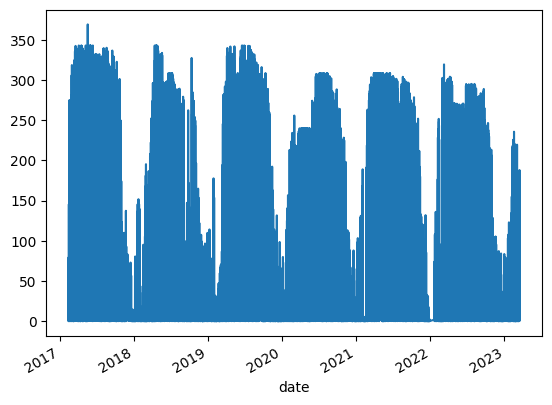

In [16]:
summplot = filtered_df['kWh']
summplot.plot()

Splitting the training and testing data:

* Train data: all data before 2021-01-01
* Test data: all data after and equal to 2021-01-01

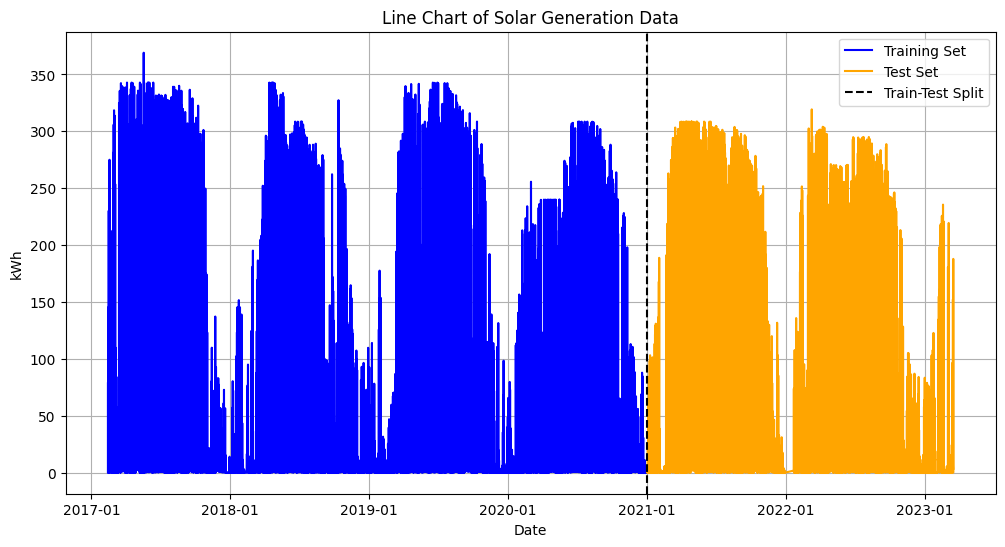

In [17]:
plt.figure(figsize=(12, 6))

split_date = '2021-01-01'

# Split the data into train and test
train = filtered_df.loc[filtered_df['date'] < split_date]
test = filtered_df.loc[filtered_df['date'] >= split_date]

plt.plot(train['date'], train['kWh'], color='blue', label='Training Set')
plt.plot(test['date'], test['kWh'], color='orange', label='Test Set')

plt.axvline(pd.to_datetime(split_date), color='black', linestyle='--', label='Train-Test Split')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(base=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.title('Line Chart of Solar Generation Data')
plt.xlabel('Date')
plt.ylabel('kWh')
plt.legend()

plt.grid()
plt.show()


### Training Model

Applying LSTM model to fit the train & test data

Epoch 1/100
561/561 - 7s - loss: 0.0215 - 7s/epoch - 13ms/step
Epoch 2/100
561/561 - 4s - loss: 0.0091 - 4s/epoch - 7ms/step
Epoch 3/100
561/561 - 4s - loss: 0.0089 - 4s/epoch - 6ms/step
Epoch 4/100
561/561 - 5s - loss: 0.0086 - 5s/epoch - 9ms/step
Epoch 5/100
561/561 - 4s - loss: 0.0084 - 4s/epoch - 6ms/step
Epoch 6/100
561/561 - 4s - loss: 0.0082 - 4s/epoch - 6ms/step
Epoch 7/100
561/561 - 6s - loss: 0.0081 - 6s/epoch - 10ms/step
Epoch 8/100
561/561 - 4s - loss: 0.0080 - 4s/epoch - 8ms/step
Epoch 9/100
561/561 - 3s - loss: 0.0080 - 3s/epoch - 6ms/step
Epoch 10/100
561/561 - 3s - loss: 0.0079 - 3s/epoch - 6ms/step
Epoch 11/100
561/561 - 5s - loss: 0.0079 - 5s/epoch - 9ms/step
Epoch 12/100
561/561 - 4s - loss: 0.0079 - 4s/epoch - 6ms/step
Epoch 13/100
561/561 - 4s - loss: 0.0079 - 4s/epoch - 6ms/step
Epoch 14/100
561/561 - 5s - loss: 0.0078 - 5s/epoch - 9ms/step
Epoch 15/100
561/561 - 4s - loss: 0.0078 - 4s/epoch - 8ms/step
Epoch 16/100
561/561 - 4s - loss: 0.0077 - 4s/epoch - 7ms/step

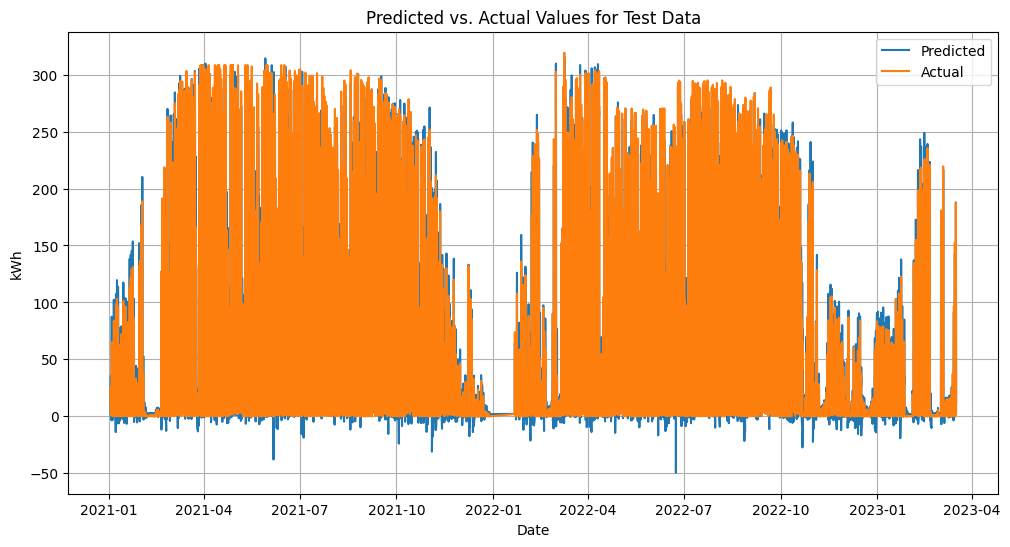

In [34]:
start_time = time.time()

# Convert the kWh data to numpy arrays
train_kWh_values = train['kWh'].values
test_kWh_values = test['kWh'].values

# Normalize data
scaler = MinMaxScaler()
train_kWh_values = scaler.fit_transform(train_kWh_values.reshape(-1, 1))
test_kWh_values = scaler.transform(test_kWh_values.reshape(-1, 1))

def prepare_data(data, look_back=1):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back)])
        y.append(data[i + look_back])
    return np.array(X), np.array(y)

look_back = 12

X_train, y_train = prepare_data(train_kWh_values, look_back)
X_test, y_test = prepare_data(test_kWh_values, look_back)

# Create LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=2)

# Model evaluation
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)

end_time = time.time()
total_time = end_time - start_time

print(f"Training Loss: {train_loss}, Testing Loss: {test_loss}")
print(f"Time taken for the process: {total_time} seconds")

# Save the trained model
model.save('lstm_model.keras')

train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)
y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)

# Plot predicted and actual values test data
plt.figure(figsize=(12, 6))
plt.plot(test.index[look_back:], test_predictions, label='Predicted')
plt.plot(test.index[look_back:], y_test, label='Actual')
plt.xlabel('Date')
plt.ylabel('kWh')
plt.title('Predicted vs. Actual Values for Test Data')
plt.legend()
plt.grid(True)
plt.show()


## Forecast (LSTM)

Below are the predictions plotted and compared to the actual values

* Train data = Blue
* Test data  = Orange
* Predicted data = Green

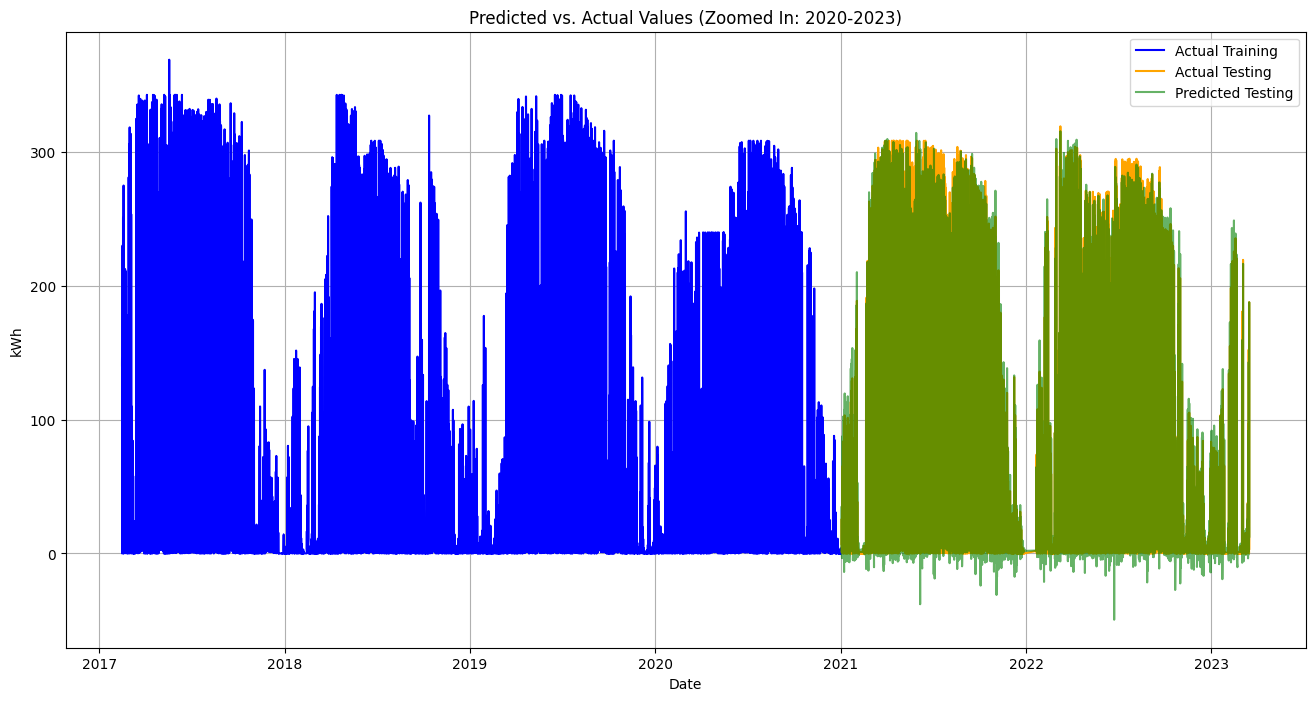

In [35]:
plt.figure(figsize=(16, 8))

plt.plot(train.index[look_back:], y_train, label='Actual Training', linestyle='-', color='blue')

plt.plot(test.index[look_back:], y_test, label='Actual Testing', linestyle='-', color='orange')

plt.plot(test.index[look_back:], test_predictions, label='Predicted Testing', color='green', zorder=3, alpha = 0.6)

plt.xlabel('Date')
plt.ylabel('kWh')
plt.title('Predicted vs. Actual Values (Zoomed In: 2020-2023)')
plt.legend()
plt.grid(True)
plt.show()

To see the bigger picture, I zoomed in around the testing/predicted data

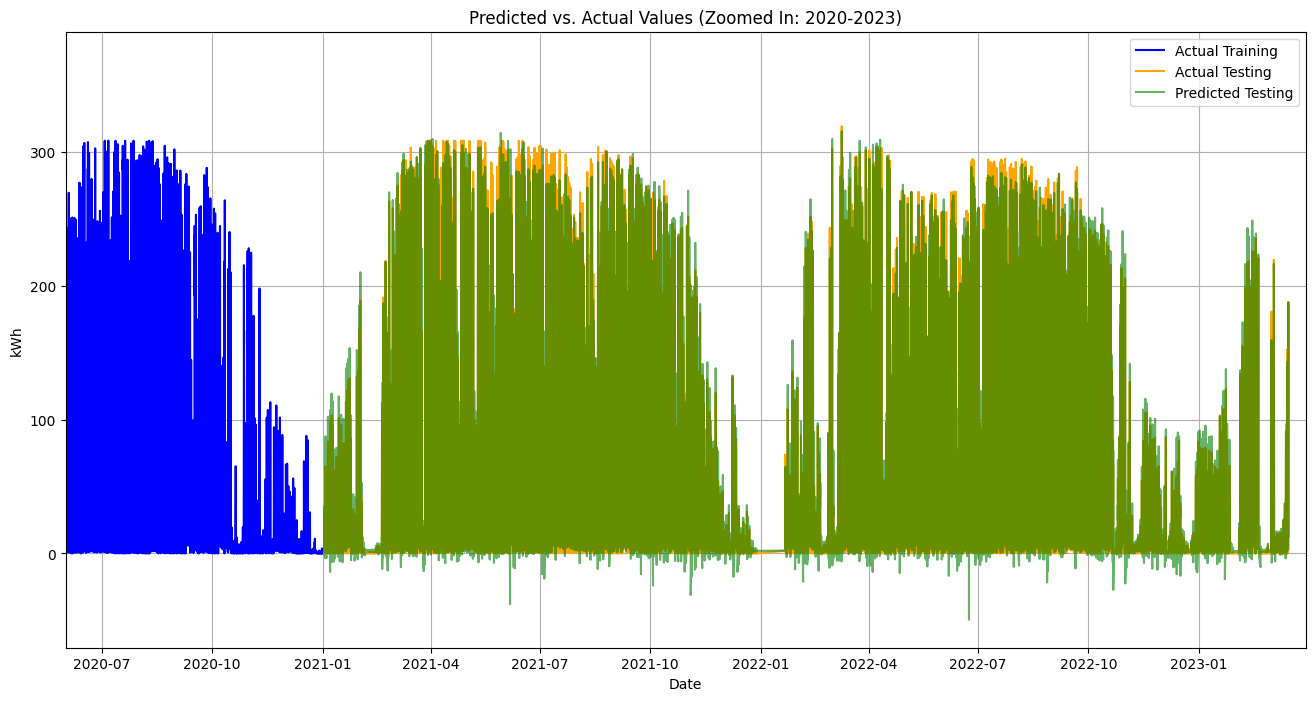

In [36]:
plt.figure(figsize=(16, 8))

plt.plot(train.index[look_back:], y_train, label='Actual Training', linestyle='-', color='blue')

plt.plot(test.index[look_back:], y_test, label='Actual Testing', linestyle='-', color='orange')

plt.plot(test.index[look_back:], test_predictions, label='Predicted Testing', color='green', zorder=3, alpha = 0.6)

plt.xlim([pd.Timestamp('2020-06-01'), pd.Timestamp('2023-03-31')])

plt.xlabel('Date')
plt.ylabel('kWh')
plt.title('Predicted vs. Actual Values (Zoomed In: 2020-2023)')
plt.legend()
plt.grid(True)
plt.show()


Monthly Prediction (1 Month)

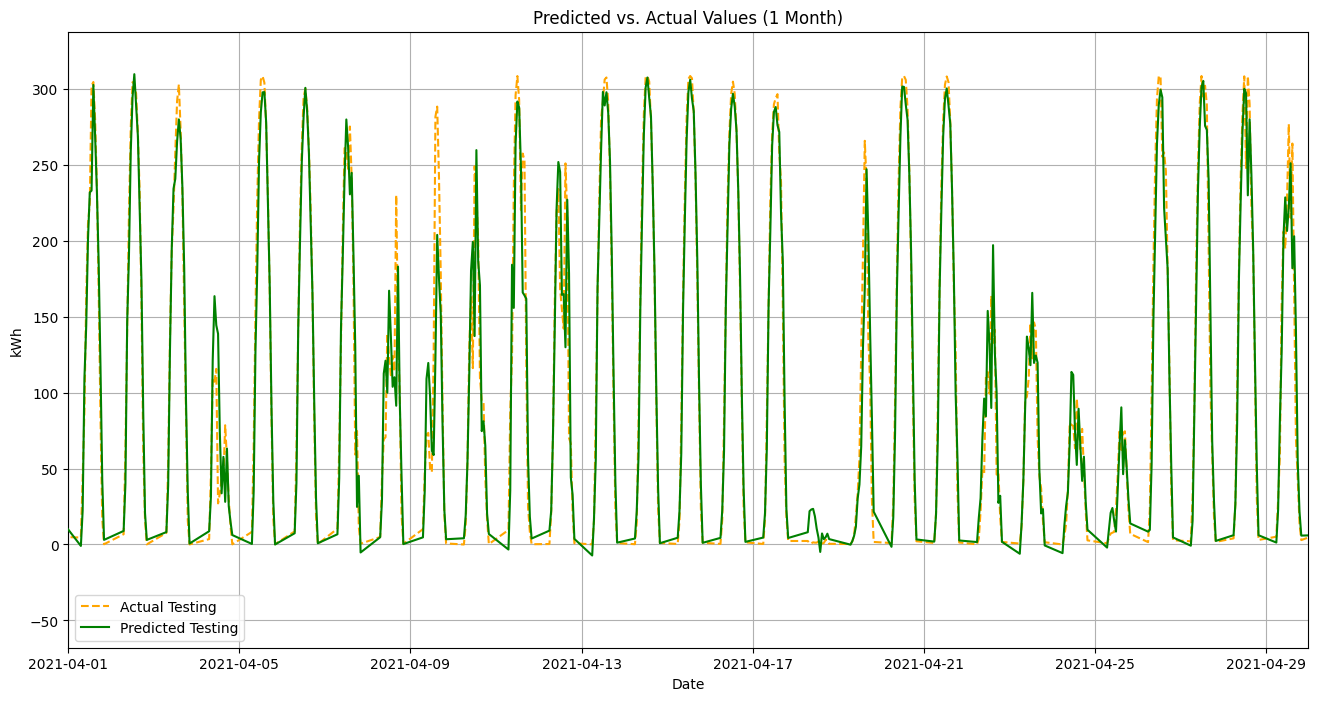

In [37]:
plt.figure(figsize=(16, 8))

plt.plot(test.index[look_back:], y_test, label='Actual Testing', linestyle='--', color='orange')

plt.plot(test.index[look_back:], test_predictions, label='Predicted Testing', color='green', zorder=3)

plt.xlim([pd.Timestamp('2021-04-01'), pd.Timestamp('2021-04-30')])

plt.xlabel('Date')
plt.ylabel('kWh')
plt.title('Predicted vs. Actual Values (1 Month)')
plt.legend()
plt.grid(True)
plt.show()

Weekly Prediction (7-days)

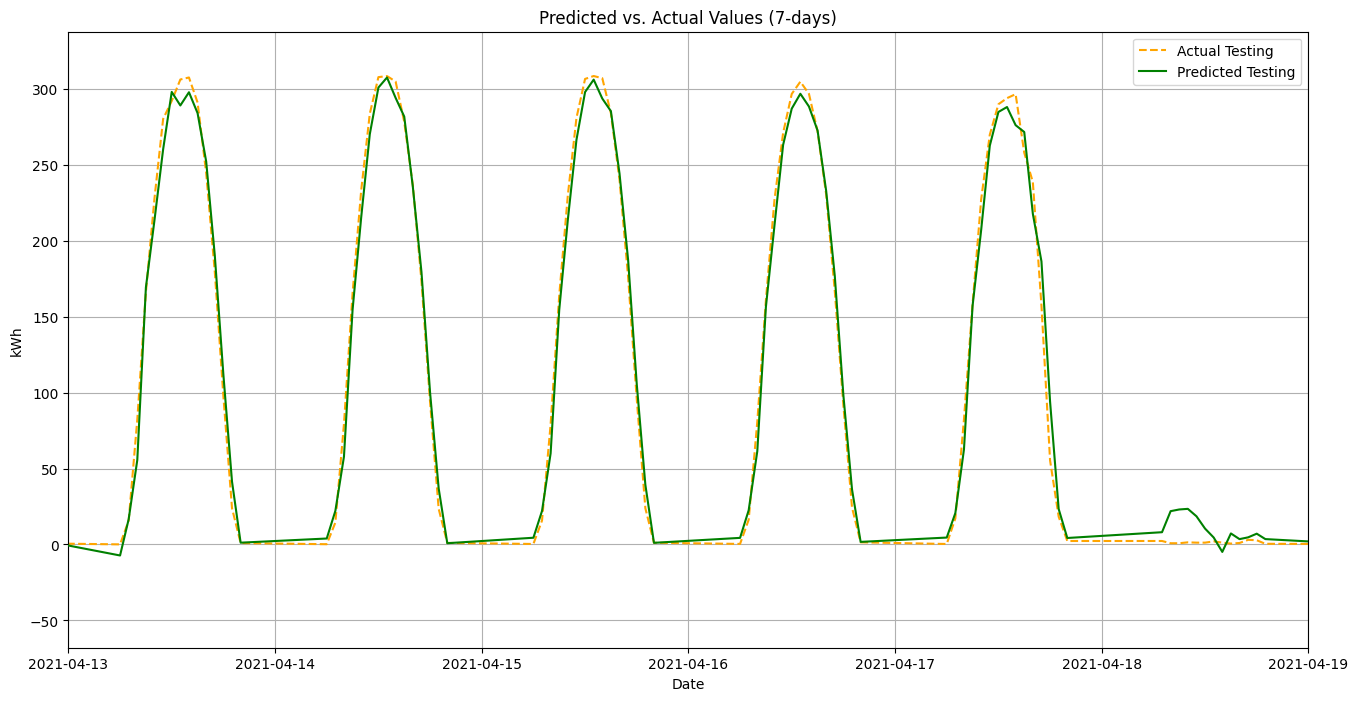

In [38]:
plt.figure(figsize=(16, 8))

plt.plot(test.index[look_back:], y_test, label='Actual Testing', linestyle='--', color='orange')

plt.plot(test.index[look_back:], test_predictions, label='Predicted Testing', color='green', zorder=3)

plt.xlim([pd.Timestamp('2021-04-13'), pd.Timestamp('2021-04-19')])

plt.xlabel('Date')
plt.ylabel('kWh')
plt.title('Predicted vs. Actual Values (7-days)')
plt.legend()
plt.grid(True)
plt.show()

Hourly Prediction (24 Hours)

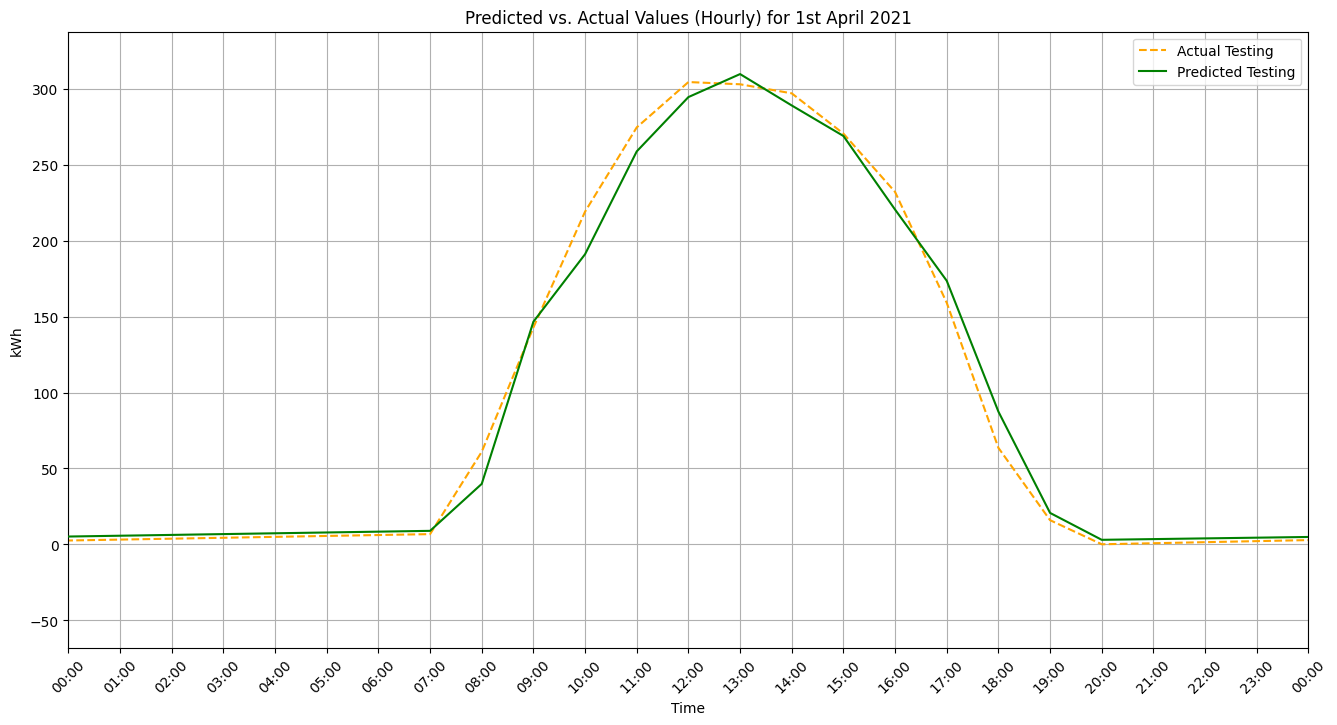

In [39]:
plt.figure(figsize=(16, 8))

plt.plot(test.index[look_back:], y_test, label='Actual Testing', linestyle='--', color='orange')

plt.plot(test.index[look_back:], test_predictions, label='Predicted Testing', color='green', zorder=3)

plt.xlim([pd.Timestamp('2021-04-2'), pd.Timestamp('2021-04-3')])

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))

plt.xticks(rotation=45)
plt.xlabel('Time')
plt.ylabel('kWh')
plt.title('Predicted vs. Actual Values (Hourly) for 1st April 2021')
plt.legend()
plt.grid(True)
plt.show()

### Actual & Prediction Values for Train/Test Data

Compare the results between predictions and actuals for train and test data

In [40]:
train_predictions = train_predictions.flatten()
y_train = y_train.flatten()

data = {'Train Predictions': train_predictions, 'Actuals': y_train}
df = pd.DataFrame(data)

print(df)

       Train Predictions  Actuals
0             110.395905  140.608
1             162.311218  145.387
2             146.802841   75.959
3              56.334778   76.037
4              69.182701   52.395
...                  ...      ...
17929           5.320436    3.786
17930           5.520187    3.685
17931           4.599582    2.525
17932           2.731360    0.576
17933           0.442743    0.005

[17934 rows x 2 columns]


In [41]:
test_predictions = test_predictions.flatten()
y_test = y_test.flatten()

data = {'Test Predictions': test_predictions, 'Actuals': y_test}
df = pd.DataFrame(data)

print(df)

      Test Predictions  Actuals
0             2.071254    7.122
1            12.209180   12.981
2            15.082343   25.740
3            35.132309   13.066
4            -0.655248    0.824
...                ...      ...
9753        172.370163  173.044
9754        147.235260  139.806
9755        101.429329   91.955
9756         54.642414   37.487
9757         12.530629    3.446

[9758 rows x 2 columns]


## Model Accuracy

### Accuracy Metrics

This part is to see the accuracy of the training and testing of the model

In [42]:
train_mse = mean_squared_error(y_train, train_predictions)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(y_train, train_predictions)
train_r2 = r2_score(y_train, train_predictions)

test_mse = mean_squared_error(y_test, test_predictions)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, test_predictions)
test_r2 = r2_score(y_test, test_predictions)

# Put metrics in dataframe
metrics = ['MSE', 'RMSE', 'MAE', 'R^2']
train_values = [train_mse, train_rmse, train_mae, train_r2]
test_values = [test_mse, test_rmse, test_mae, test_r2]

accuracy_df = pd.DataFrame({'Metrics': metrics, 'Training Data': train_values, 'Testing Data': test_values})
accuracy_df.set_index('Metrics', inplace=True)

print(accuracy_df)

         Training Data  Testing Data
Metrics                             
MSE         875.540958    838.433628
RMSE         29.589541     28.955718
MAE          18.305535     18.043661
R^2           0.909975      0.902544


### Result Findings

Based on the metrics, it is found that the model is a good fit to the test data at 0.9 which is an unseen data. The closer it is to 1, the better it is. The RMSE and MAE is also on the low side which conveys that the error rate for the prediction is low.

The graph for prediction also provide a high accuracy prediction in all the time frames that I have tested.

For non-technical viewers/readers, I recommend to look at the prediction vs actual plot because it can be interpreted easily.

### Improvements

* Compare with other models
* More computing resources
* Test new data and update model

## Forecast using new data here

### Use saved model on future data (2023 data and above)

In [ ]:
# from tensorflow.keras.models import load_model

# # Load saved model here
# model = load_model('lstm_model.keras')

In [ ]:
# new_data = 'new_dataset' #load new data here

# new_data = scaler.transform(new_data.reshape(-1, 1))

# X_new = []
# for i in range(len(new_data) - look_back):
#     X_new.append(new_data[i:(i + look_back)])
# X_new = np.array(X_new)

# predictions = model.predict(X_new)

# predictions = scaler.inverse_transform(predictions)

## SARIMA Model (Currently discontinued due to lack of computing resources)

SARIMA model below was made to support the seasonality that was contained in the dataset. I parsed the data through chunks of 100 to reduce RAM usage.

Autocorrelation function (ACF) and Partial Autocorrelation Function (PACF) were used to find the seasonality and find differencing to make the data stationary. Values below were gained through ACF and PACF:


* p
=
 	order of the autoregressive part;
* d
=
 	degree of first differencing involved;
* q
=
 	order of the moving average part.

* m = seasonal period

### ACF & PACF

Getting values for seasonal(P, D, Q) & non-seasonal(p, d, q)

In [ ]:
# train.dtypes

In [ ]:
# train.head()

In [ ]:
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# # Use the 'kWh' column from your 'train' DataFrame as the time series data
# f = train['kWh']

# # Plot the ACF
# plot_acf(f, lags=24)  # Adjust the number of lags as needed
# plt.title('ACF')

# # Plot the PACF
# plot_pacf(f, lags=24)  # Adjust the number of lags as needed
# plt.title('PACF')

# plt.show()


PACF plot cuts off or drops to zero. p=2,
Train data differencing. d=1,
ACF seasonality D= 1,
seasonal period (s) = 24

1,1


### Training Model (SARIMA)

In [ ]:
# pip install pmdarima

In [ ]:
# from statsmodels.tsa.stattools import adfuller

# # Apply Dickey-Fuller test
# result = adfuller(train['kWh'])

# test_statistic = result[0]
# p_value = result[1]

# print(f"Test Statistic: {test_statistic}")
# print(f"P-Value: {p_value}")

# if p_value <= 0.05:
#     print("The time series is stationary (reject the null hypothesis).")
# else:
#     print("The time series is non-stationary (fail to reject the null hypothesis).")

In [ ]:
# import warnings

# warnings.filterwarnings("ignore", message="An unsupported index was provided and will be ignored when e.g. forecasting.")

In [ ]:
# # import pmdarima as pm
# from statsmodels.tsa.statespace.sarimax import SARIMAX
# import time
# import pickle

# chunk_size = 100

# # Store forecasted data
# forecasted_data = []

# # Store processed chunks
# processed_chunks = []

# # Split the data into chunks and process them one by one
# start_time = time.time()
# chunk_count = 0


# for i in range(0, len(train), chunk_size):
#     train_chunk = train[i:i+chunk_size]

#     timestamp_index = pd.date_range(start='2017-02-13', periods=len(train_chunk), freq='H')
#     train_chunk.index = timestamp_index

#     try:
#         # model = SARIMAX(train_chunk['kWh'], order=(1, 0, 8), seasonal_order=(2, 1, 1, 24))
#         model = SARIMAX(train_chunk['kWh'], order=(1, 0, 8), seasonal_order=(1, 1, 1, 24))
#         # model = SARIMAX(train_chunk['kWh'], order=(0, 0, 0), seasonal_order=(0, 0, 0, 0))
#         # model_fit = model.fit()
#         model_fit = model.fit(method='bfgs', maxiter=1000)  # Increase the maximum number of iterations


#         # Forecast future data for the test set
#         forecast_chunk = model_fit.forecast(steps=len(test))

#         # Append the forecasted data to the list
#         forecasted_data.append(forecast_chunk)

#         # Append the processed chunk
#         processed_chunks.append(train_chunk)

#         chunk_count += 1

#         # Save the progress using pickle
#         with open('saved_data.pkl', 'wb') as savepoint_file:
#             savepoint = {
#                 'processed_chunks': processed_chunks,
#                 'forecasted_data': forecasted_data
#             }
#             pickle.dump(savepoint, savepoint_file)

#     except Exception as e:
#         # If an exception occurs (e.g., a crash), save the progress
#         print(f"An exception occurred: {str(e)}")
#         break  # Exit the loop when an exception occurs

# end_time = time.time()
# time_taken = end_time - start_time
# print(f"Time taken: {time_taken} seconds")
# print(f"Total chunks processed: {chunk_count}")